<a href="https://colab.research.google.com/github/ekramasif/SMS-Spam-Prediction-Using-BERT/blob/main/SMS_Spam_Prediction_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip3 install --quiet tensorflow
!pip3 install --quiet tensorflow_text

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/spam.csv', encoding = "ISO-8859-1")
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [40]:
df.groupby('v1').describe()

v2         ... Unnamed: 4     
     count unique  ...        top freq
v1                 ...                
ham   4825   4516  ...    GNT:-)"    2
spam   747    653  ...        NaN  NaN

[2 rows x 16 columns]

In [41]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [42]:
df_spam = df[df['v1']=='spam']
df_spam.shape

(747, 5)

In [43]:
df_ham = df[df['v1']=='ham']
df_ham.shape


(4825, 5)

In [44]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 5)

In [45]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 5)

In [46]:
df_balanced['v1'].value_counts()

ham     747
spam    747
Name: v1, dtype: int64

In [47]:
df_balanced['spam']=df_balanced['v1'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
942,spam,How about getting in touch with folks waiting ...,NaN,NaN,NaN,1
2278,ham,Hmm...Bad news...Hype park plaza $700 studio t...,NaN,NaN,NaN,0
15,spam,"XXXMobileMovieClub: To use your credit, click ...",NaN,NaN,NaN,1
2327,spam,URGENT! Your mobile number *************** WON...,NaN,NaN,NaN,1
5214,spam,Natalja (25/F) is inviting you to be her frien...,NaN,NaN,NaN,1


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['v2'],df_balanced['spam'], stratify=df_balanced['spam'])

In [49]:
X_train.head(5)

1210            Guessin you ain't gonna be here before 9?
2       Free entry in 2 a wkly comp to win FA Cup fina...
1672    URGENT! We are trying to contact U. Todays dra...
4297    WELL DONE! Your 4* Costa Del Sol Holiday or å£...
4890    Its worse if if uses half way then stops. Its ...
Name: v2, dtype: object

In [50]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [51]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [53]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [54]:
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
35/35 [==============================] - 34s 655ms/step - loss: 0.5814 - accuracy: 0.7455 - precision: 0.7425 - recall: 0.7518
Epoch 2/15
35/35 [==============================] - 23s 653ms/step - loss: 0.4721 - accuracy: 0.8420 - precision: 0.8342 - recall: 0.8536
Epoch 3/15
35/35 [==============================] - 23s 652ms/step - loss: 0.4124 - accuracy: 0.8732 - precision: 0.8542 - recall: 0.9000
Epoch 4/15
35/35 [==============================] - 23s 652ms/step - loss: 0.3777 - accuracy: 0.8723 - precision: 0.8626 - recall: 0.8857
Epoch 5/15
35/35 [==============================] - 23s 652ms/step - loss: 0.3442 - accuracy: 0.8893 - precision: 0.8707 - recall: 0.9143
Epoch 6/15
35/35 [==============================] - 23s 653ms/step - loss: 0.3334 - accuracy: 0.8893 - precision: 0.8811 - recall: 0.9000
Epoch 7/15
35/35 [==============================] - 23s 655ms/step - loss: 0.3215 - accuracy: 0.8893 - precision: 0.8772 - recall: 0.9054
Epoch 8/15
35/35 [================

In [55]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 9s 632ms/step - loss: 0.2249 - accuracy: 0.9332 - precision: 0.9175 - recall: 0.9519


[0.22493046522140503,
 0.9331550598144531,
 0.9175257682800293,
 0.9518716335296631]

In [56]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [57]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[171,  16],
       [  9, 178]])

Text(33.0, 0.5, 'Truth')

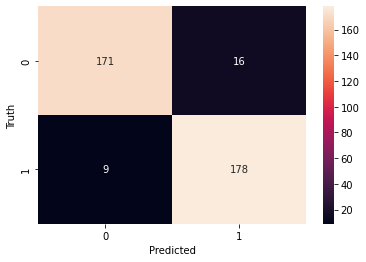

In [59]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [60]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       187
           1       0.92      0.95      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [64]:
'''Spam = 1 Ham = 0'''

reviews = [
    'Hey, are you comming univarsity tomorrow?',
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'Good but you can do better',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'Life sucks but you can make it beautiful',
    'Congrats,You won $1000 now give this money to poor people',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
result = model.predict(reviews)

print(np.round(result))

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]
